# Getting Started on the Descartes Labs Platform

The Descartes Labs platform offers the ability to search terrabytes of satellite imagery, perform analysis in a python development environment, and offers the compute capacity to scale analytics to large regions. This quickstart tutorial demonstrates the basic functionality of our core APIs. if searching for imagery over a geometry that is free of clouds using the ```Places``` and ```Metadata``` APIs. We then use the ```Raster``` API to access the data as a ```numpy.array``` and plot the data using ```Matplotlib```.

First, we import a few standard libraries that make life easier:

In [1]:
# import os
import warnings
from pprint import pprint

Next, we import the Descartes Labs platform. If you haven't yet, visit the documentation to learn how to install and authenticate our library. 

In [2]:
import descarteslabs as dl

## Find our Area of Interest: El Dorado County

Let's use the ```Places``` API to locate El Dorado County, California, home to Eldorado National Forest. Eldorado is nestled between Lake Tahoe and Yosemite National Park in the Sierra Nevada Mountain Range. It experienced a devastating fire in 2014, which will be fun to view using different band combinations on our platform. 

In [3]:
# Find potential matches
matches = dl.places.find('california_el-dorado')
print(len(matches))

1


Looks like there is only one possible El Dorado, California! Let's see what it looks like ...

In [4]:
pprint(matches[0])

{
  u'bbox': [-121.141009, 38.502349, -119.877287, 39.067489],
  u'id': 102086953,
  u'name': u'El Dorado',
  u'path': u'continent:north-america_country:united-st..._district:sierra-mountains_county:el-dorado',
  u'placetype': u'county',
  u'slug': u'north-america_united-states_california_sierra-mountains_el-dorado'
}


That looks like the correct. To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case accessing a low-resolution version of this particular shape.

In [5]:
shape = dl.places.shape(matches[0]['slug'], geom='low')
pprint(shape)

{
  u'bbox': [-121.141009, 38.502349, -119.877287, 39.067489],
  u'geometry': {
    u'coordinates': [
      [
        [-120.184433, 39.031008],
        [-120.18356, 39.038372],
        [-120.165028, 39.038485],
        [-120.164964, 39.045787],
        ...
      ]
    ],
    u'type': u'Polygon'
  },
  u'id': 102086953,
  u'properties': {
    u'name': u'El Dorado',
    u'parent_id': 303999025,
    u'path': u'continent:north-america_country:united-st..._district:sierra-mountains_county:el-dorado',
    u'placetype': u'county',
    u'slug': u'north-america_united-states_california_sierra-mountains_el-dorado'
  },
  u'type': u'Feature'
}


## Search for the latest "Cloud Free" Landsat image we can find 

Here we’ll use the ```Metadata``` API to search for available imagery over a spatio-temporal extent. In this case we’ll specify that we’re interested in our aoi using its slug for Months of Feburary and March, 2018.

First, let's demonstrate the currently available products you have access to on our platform. We also need to grab the ```product_id``` for the Landsat 8 constellation. 

In [95]:
# What imagery is available?
sources = dl.metadata.sources()
pprint(sources)

[
  {
    u'product': u'modis:09:CREFL',
    u'sat_id': u'Terra'
  },
  {
    u'product': u'modis:09:CREFL',
    u'sat_id': u'Aqua'
  },
  {
    u'product': u'sentinel-2:L1C',
    u'sat_id': u'S2A'
  },
  {
    u'product': u'sentinel-2:L1C',
    u'sat_id': u'S2B'
  },
  {
    u'product': u'landsat:LE07:PRE:TOAR',
    u'sat_id': u'LANDSAT_7'
  },
  {
    u'product': u'landsat:LE07:PRE:TOAR',
    u'sat_id': u'Landsat7'
  },
  {
    u'product': u'landsat:LT05:PRE:TOAR',
    u'sat_id': u'LANDSAT_5'
  },
  {
    u'product': u'landsat:LT05:PRE:TOAR',
    u'sat_id': u'Landsat5'
  },
  {
    u'product': u'sentinel-3:OLCI_RGB',
    u'sat_id': u'S3A'
  },
  {
    u'product': u'landsat:LC08:PRE:TOAR',
    u'sat_id': u'LANDSAT_8'
  },
  {
    u'product': u'sentinel-1:GRD',
    u'sat_id': u'SENTINEL-1A'
  },
  {
    u'product': u'sentinel-1:GRD',
    u'sat_id': u'SENTINEL-1B'
  },
  {
    u'product': u'5151d2825f5e29ff129f86d834946363ff3f7e57:modis:09:CREFL_v2_test',
    u'sat_id': u'Aqua'
  },
  {

From the product can list, we select the Landsat 8 top of atmospheric reflectence ```product_id```. We will pass this ```id``` into a call to ```metadata.search()```, with the additional parameters specifying our geojson for El Dorado defined above, a time period spanning the last few months, and filtering for scenes with less than 30% cloud cover using the ```cloud_fraction``` parameter.

In [56]:
import json
feature_collection = dl.metadata.search(products='landsat:LC08:01:T1:TOAR', 
                                        start_time='2018-02-01',
                                        end_time='2018-03-25', 
                                        limit=10,
                                        cloud_fraction=.25,
                                        place=matches[0]['slug'])
# As the variable name implies, this returns a FeatureCollection GeoJSON dictionary.
# Its 'features' are the available scenes.
print (len(feature_collection['features']))

3


The ```id``` associated with each feature is a unique identifier into our imagery database. Here, I print out the aquisition date, id, and cloud cover of all scenes that meet our original criteria so we can pick select the lastest & least cloudy image. 

In [57]:
for f in feature_collection['features']:
    pprint(f['id'])
    print ('Date: {} Cloud cover: {}'.format(f['properties']['acquired'], f['properties']['cloud_fraction']))

u'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_043033_20180202_20180220_01_T1_v1'
Date: 2018-02-02T18:39:22.225769Z Cloud cover: 0.0262
u'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_044033_20180209_20180222_01_T1_v1'
Date: 2018-02-09T18:45:31.126285Z Cloud cover: 0.2221
u'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_044033_20180225_20180308_01_T1_v1'
Date: 2018-02-25T18:45:24.780215Z Cloud cover: 0.0782


We can programmatically select the latest image like so:

In [74]:
latest_scene = feature_collection['features'][-1]['id']

The last ```Metadata``` call we will make is to inspect the bands associated with our product. This will come in handy for visualization and for exporting the image from our environment. 

In [66]:
band_information = dl.metadata.bands('landsat:LC08:01:T1:TOAR')
bands = [band['name'] for band in band_information]
print(bands)

[u'coastal-aerosol', u'blue', u'green', u'red', u'nir', u'swir1', u'swir2', u'cirrus', u'tirs1', u'alpha', u'bright-mask', u'cloud-mask', u'qa_cirrus', u'qa_cloud', u'qa_cloud_shadow', u'qa_saturated', u'qa_snow', u'valid-cloudfree']


In [81]:
ids = [f['id'] for f in feature_collection['features']]

## Visualize the image
Next, we will use the ```Raster``` API to visualize the scene. To do this with the library ```Matplotlib```, we gather the data into an ```Numpy``` array. The code below makes a call to ```raster.ndarray``` passing all the scene ```id```s, true color bands, scale the incoming data with range [0, 10000] down to [0, 4000], and choose a 60m resolution, and apply a cutline of El Dorado County.

In [82]:
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry']
)

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.

In [77]:
# We'll use matplotlib to make a quick plot of the image.
import matplotlib.pyplot as plt
%matplotlib inline

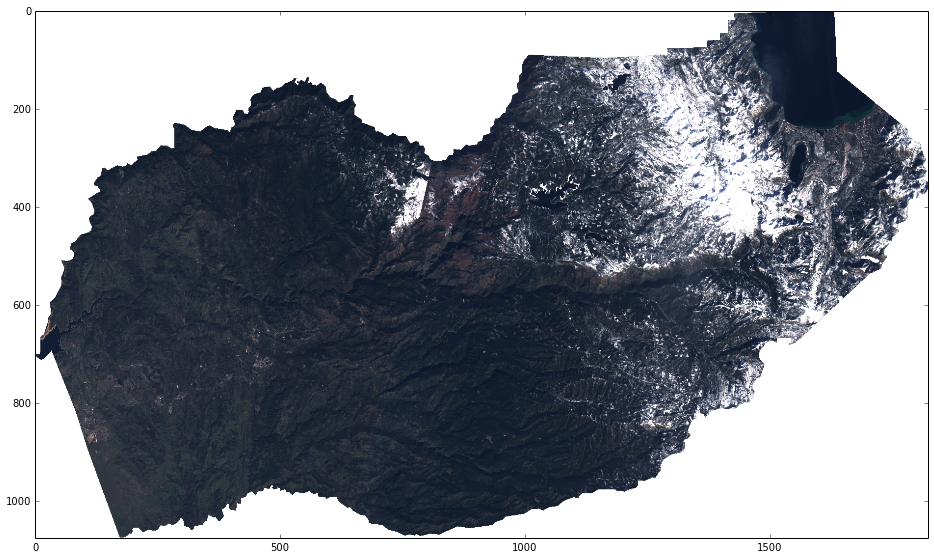

In [83]:
plt.figure(figsize=[16,16])
plt.imshow(arr)

Alternatively, once you have the data in a ```Numpy``` array, you can perform rapid analysis on the composited data. This includes doing things like computing burn indicies to identify the extent of fires, conducting land change analysis, or performing land cover classifications.

## Download the image 
The ```Raster``` API also supports the ability to download data as an image. The parameters are similar to the call to ```ndarray```, with the additional parameters ```output_format```, ```save```, and ```outfile_basename```. This option is not necessary in most workflows, as the Descartes Labs platform allows for rapid and efficient analysis in this environment, however, it will serve to demonstrate how to ingest user-owned and created imagery into our platform.


We will include the near infrared and both short wave infrared bands in our export. We will want to access that in the platform to view unique features.

In [92]:
export_bands = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']

In [93]:
arr, meta = dl.raster.raster(
    ids,
    bands= export_bands,
    scales=[[0,4000], [0, 4000], [0, 4000], [0, 4000], [0, 4000], [0, 4000]],
    output_format='GTiff',
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry'],
    save=True,
    outfile_basename="eldorado"
)

## Upload an image to the Descartes Labs platform
The ```Catalog``` API allows users to ingest their raster datasets into the platform, giving you access to our massive analytical and computer power for use on your data. It also makes it easy for you to use your own data along side a cannon of publically available imagery and dervied projects. This is an alpha feature, so you should make sure you've followed the instructions for accessing these classes. 

First, we have to import the ```Catalog``` API.

In [94]:
from descarteslabs.client.services import Catalog

The first step to getting your personal data into the Descartes Labs platform is to add an entry into our product database. The first parameter is a string indicating the ```product_id```. The only other two required parameters are a product ```title``` and ```description```, both strings. There are many more optional parameters that can be passed in documented in the API reference. 

In [97]:
Catalog().add_product('eldorado_example', 
                      title='El Dorado Composite', 
                      description='Demo for platform users. This is a composited and clipped Landsat raster of El Dorado County in California. The image contains five bands for visualization and analytical purposes. It was exported from the Descartes Labs platform.'
                     )

{u'data': {u'attributes': {u'description': u'Demo for platform users. This is a composited and clipped Landsat raster of El Dorado County in California. The image contains five bands for visualization and analytical purposes. It was exported from the Descartes Labs platform.',
   u'read': [],
   u'title': u'El Dorado Composite'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:eldorado_example',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'type': u'product'}}

It returns an object containing the most important piece of information, your new product's ```id```. This will be used in the next to calls to fully ingest your data into our system. 

The next step is to add band information to your product's entry. This will give you full access to your data in the Descartes Labs Viewer, Catalog, and in the platform. The code below iterates through the list of bands we exported, adding each individually. The first parameter for each band is the ```id``` of the product we just created. The second is the band's ```name```. There are a range of required and non-required parameters that can be added documented in the API reference.

In [99]:
for i, band in enumerate(export_bands):
       
        band_id = Catalog().add_band(
            '7294028cc01114d89a473cf055d29dc5cd5ffe88:eldorado_example', # id of the product we just created.
            '{}'.format(band),
            jpx_layer=0,
            srcfile=0,
            srcband=i+1,  # src band is always a 1-based index (counting starts at 1)
            nbits=16,
            dtype='UInt16',
            nodata=0,
            data_range=[0, 255],
            type='spectral',
             default_range=(0,4000),
        )['data']['id']

In [ ]:
# catalog.upload_image(image, product_id, acquired=acquired_date)
acquired_date = '2018-01-09'
Catalog().upload_image('/Users/karlaking/descarteslabs-code/test-tutorials/taos.tif', '7294028cc01114d89a473cf055d29dc5cd5ffe88:taos_example', acquired=acquired_date)